In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import IPython.display as display
import PIL.Image
import functools

In [25]:
content_path = "content1.jpg"
style_path = "style2.jfif"

In [26]:
def tensor_to_image(tf_input):
    tf_input = tf_input*255
    tf_input = np.array(tf_input, dtype = np.uint8)
    if np.ndim(tf_input)>3:
        assert tf_input.shape[0] == 1
        tf_input = tf_input[0]
    return PIL.Image.fromarray(tf_input)

In [27]:
def load_image(path):
    #read image from its path
    img = tf.io.read_file(path)
    #detects type of image and convert it into tensor
    img = tf.image.decode_image(img, channels = 3)
    #convert pixels to float
    img = tf.image.convert_image_dtype(img, tf.float32)
    #detects height and width as float
    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    max_dim = 512
    scale = max_dim/long_dim
    new_shape = tf.cast(shape * scale, tf.int32)
    img = tf.image.resize(img, new_shape)
    #increase the dimension
    img = img[tf.newaxis, :]
    return img

In [28]:
def imshow(image, title = None):
    if(len(image.shape)>3):
        image = tf.squeeze(image, axis =0)
    plt.imshow(image)
    if title:
        plt.title(title)

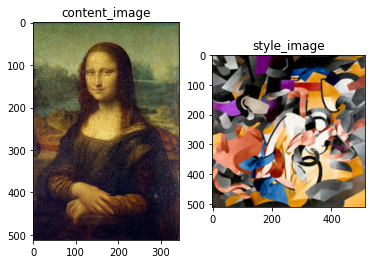

In [29]:
content_image = load_image(content_path)
style_image = load_image(style_path)

plt.subplot(1, 2, 1)
imshow(content_image, "content_image")

plt.subplot(1, 2, 2)
imshow(style_image, "style_image")

In [30]:
vgg = tf.keras.applications.VGG19(include_top = False, weights = 'imagenet')

In [31]:
for layers in vgg.layers:
    print(layers.name)

input_3
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [32]:
content_layers = ['block5_conv2']
num_content_layers = len(content_layers)

In [33]:
style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']
num_style_layers = len(style_layers)

In [34]:
def vgg_layers(layer_names):
    # Load our model. Load pretrained VGG, trained on imagenet data
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False
    outputs = [vgg.get_layer(name).output for name in layer_names]
    model = tf.keras.Model([vgg.input], outputs)
    return model

In [35]:
def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor) #forms the gram matrix.
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result/(num_locations)

In [36]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2)for name in style_outputs.keys()])
    #reduce_mean Computes the mean of elements across dimensions of a tensor.
    #add_n Adds all input tensors element-wise.
    style_loss *= style_weight / num_style_layers
    #division is done so as to get style loss per layer
    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2)for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

In [37]:
def high_pass_x_y(image):
    x_var = image[:,:,1:,:] - image[:,:,:-1,:]
    y_var = image[:,1:,:,:] - image[:,:-1,:,:]
    return x_var, y_var

In [38]:
def total_variation_loss(image):
    x_deltas, y_deltas = high_pass_x_y(image)
    return tf.reduce_mean(tf.abs(x_deltas)) + tf.reduce_mean(tf.abs(y_deltas**2))

In [39]:
style_weight = 1e-2
content_weight = 1e4
total_variation_weight = 1e4

In [40]:
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1 = 0.99, epsilon = 1e-1)

In [41]:
class StyleContentModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super(StyleContentModel, self).__init__()
        self.vgg =  vgg_layers(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False
        
    def call(self, inputs):
        """Expects float input in [0, 1]"""
        
        inputs = inputs*255.0
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs) # ENCODES A BATCH OF IMAGES TO THE VGG19 MODEL
        # this step does the remaining preprocessing like mean subtraction on the image before sending it to the model
        outputs = self.vgg(preprocessed_input)
        style_outputs, content_outputs = (outputs[:self.num_style_layers],outputs[self.num_style_layers:])
        style_outputs = [gram_matrix(style_output)for style_output in style_outputs]
        content_dict = {content_name:value for content_name, value in zip(self.content_layers, content_outputs)}
        style_dict = {style_name:value for style_name, value in zip(self.style_layers, style_outputs)}
        return {'content':content_dict, 'style':style_dict}

In [42]:
extractor = StyleContentModel(style_layers, content_layers)

In [43]:
image = tf.Variable(content_image)

In [44]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

In [45]:
def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [46]:
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs)
        loss += total_variation_weight*tf.image.total_variation(image)
    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))

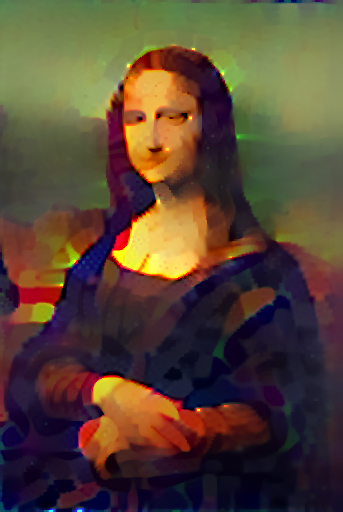

Train step: 300
Total time: 1341.4


In [47]:
start = time.time()
epochs = 30
steps_per_epoch = 10
step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(image)
        print(".", end='')
    display.clear_output(wait = True)
    display.display(tensor_to_image(image))
    print("Train step: {}".format(step))
end = time.time()
print("Total time: {:.1f}".format(end-start))